# PMCSC Services2 анализ анкеты

In [247]:
# Ensure all the libraries are installed
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import math
import matplotlib.pyplot as plt
import numpy as np
# Workaround for the issue: https://github.com/pandas-dev/pandas/issues/26314
# pip install pandas==0.21
import pandas as pd
import os
import re
import sys
import seaborn as sns

import matplotlib.cm as cm
from matplotlib.backends.backend_pdf import PdfPages

# Fix random seed
np.random.seed(0)

In [248]:
df = pd.read_csv('survey.tsv', sep='\t')

In [264]:
print(f'Total answers {len(df)}')
# df

Total answers 57


In [250]:
# Fix missing question from the beginning
df['Укажите Ваш пол'].fillna('Женщина', inplace=True)

In [251]:
# Cleanup columns
df.columns = [c.replace('\xa0', '') for c in df.columns]

In [252]:
services = set([re.sub('(.*\\[)|]', '', c) for c in df.columns if ']' in c])
services

{'макияж',
 'маникюр',
 'окрашивание / тонирование',
 'педикюр',
 'стрижка / услуги барбера',
 'укладка'}

In [253]:
questions = set([re.sub('\\[.*|', '', c).strip() for c in df.columns if '[' in c])
questions

{'Где предпочитаете оказание услуги?',
 'Ищите ли Вы примеры работ и как часто?',
 'Как часто Вы меняете мастера?',
 'Какими услугами и как часто Вы пользуетесь?',
 'На что ориентируетесь при выборе мастера в первую очередь (2 основных)',
 'Почему Вы ищете нового мастера?',
 'Сколько вы платите за услуги за один сеанс?'}

In [295]:
PRICE_ORDER = ['меньше 1000р', '1000-1500р', '1500-2000р', '2000-3000р', 
               '3000-5000р', '5000-7000р', '7000-10000р', 'больше 10000р']
# 0 added for N/A
PRICES = dict(zip(['0'] + PRICE_ORDER, [0, 500, 1250, 1750, 2500, 4000, 6000, 8500, 10000]))

REG_ORDER = ['реже чем 1 раз в год', 'раз в год', '2-3 раза в год', '4-6 раз в год', 'чаще 6 раз в год']
REGULARITY = dict(zip(REG_ORDER, [0.5, 1, 2.5, 5, 8]))

In [296]:
def plot_answers(df, q):
    dfq = df[[c for c in df.columns if q in c]]
    dfq.columns = [next(s for s in services if s in c) for c in dfq.columns]
    dfq = pd.DataFrame(dfq.stack()).reset_index(drop=False)
    dfq = dfq.drop(columns=['level_0'])
    dfq.replace(regex=r'лайки, комменты', value='лайки или комменты', inplace=True)
    dfq.columns = ['service', 'answer']
    # Split multiple options
    dfq = dfq.set_index(['service']).apply(lambda x: x.str.split(r'[ ]?,[ ]?').explode()).reset_index()
    dfq = dfq.groupby(['service', 'answer']).size().reset_index()
    dfq.rename({0: 'count'}, axis=1, inplace=True)
    if any(a == '2-3 раза в год' for a in dfq['answer']):
        sns.barplot(x='service', y='count', hue='answer', data=dfq, 
                    hue_order=dict(zip(REG_ORDER, range(len(REG_ORDER)))))
    elif any('000р' in str(a) for a in dfq['answer']):
        sns.barplot(x='service', y='count', hue='answer', data=dfq, 
                    hue_order=dict(zip(PRICE_ORDER, range(len(PRICE_ORDER)))))        
    else:
        sns.barplot(x='service', y='count', hue='answer', data=dfq)
    # Rotate ticks
    plt.xticks(rotation=90)
    # Put the legend out of the figure
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(q)
    plt.show()

## Вопросы по услугам

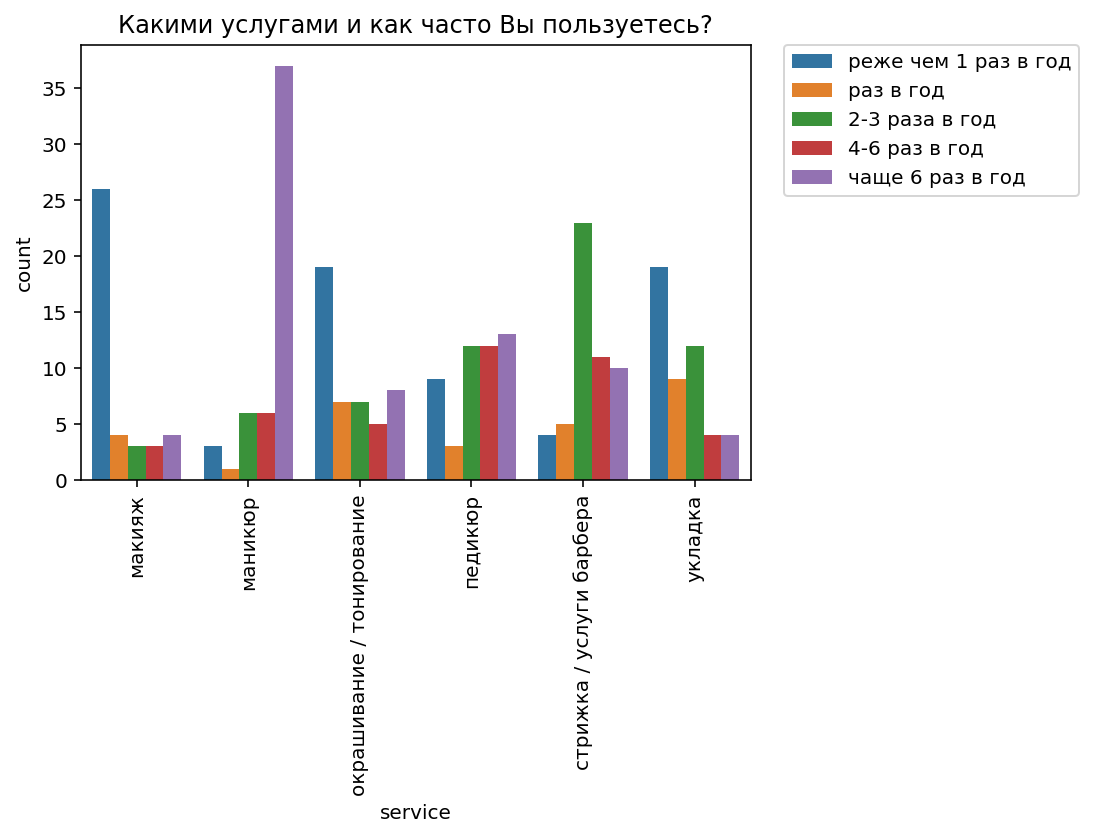

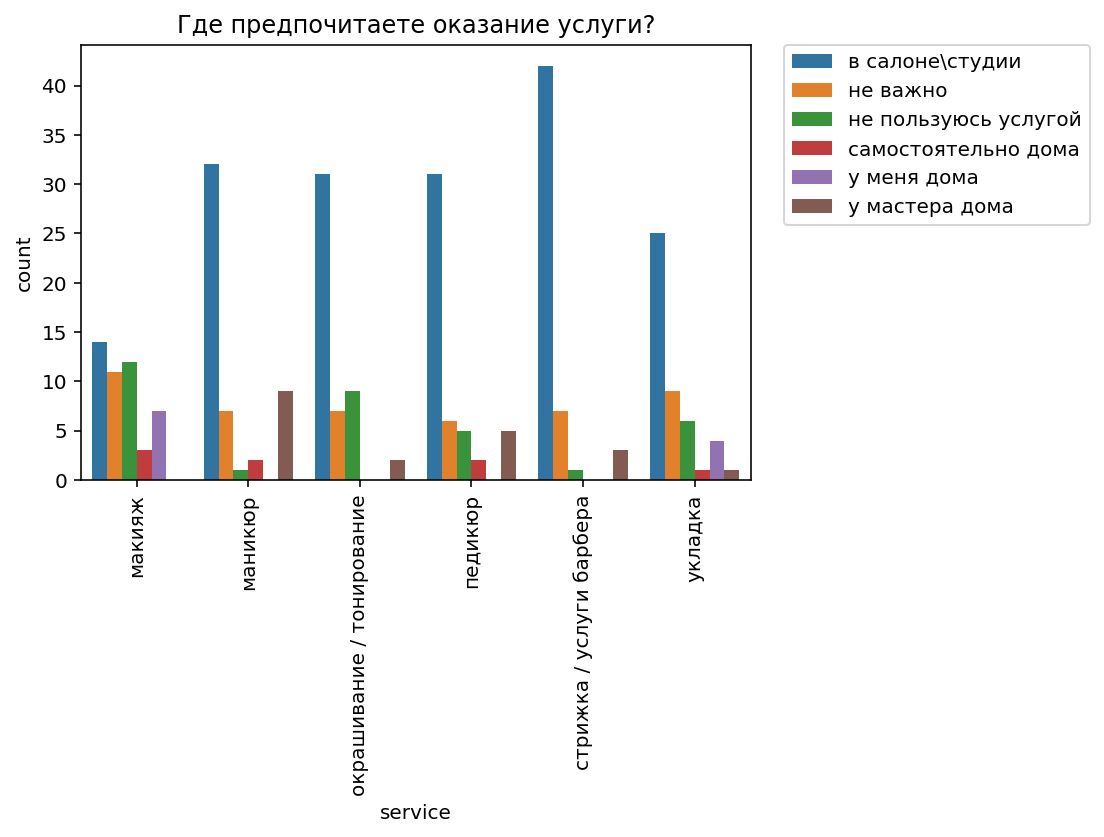

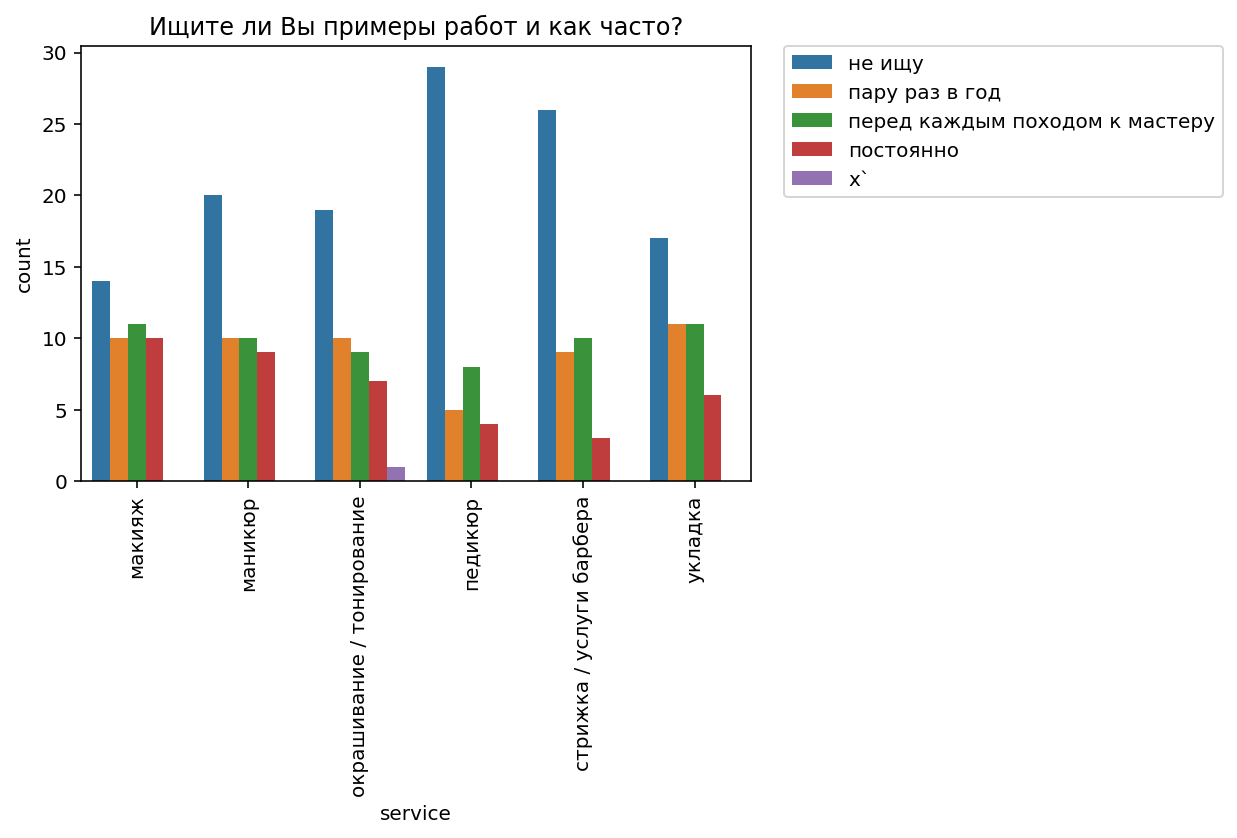

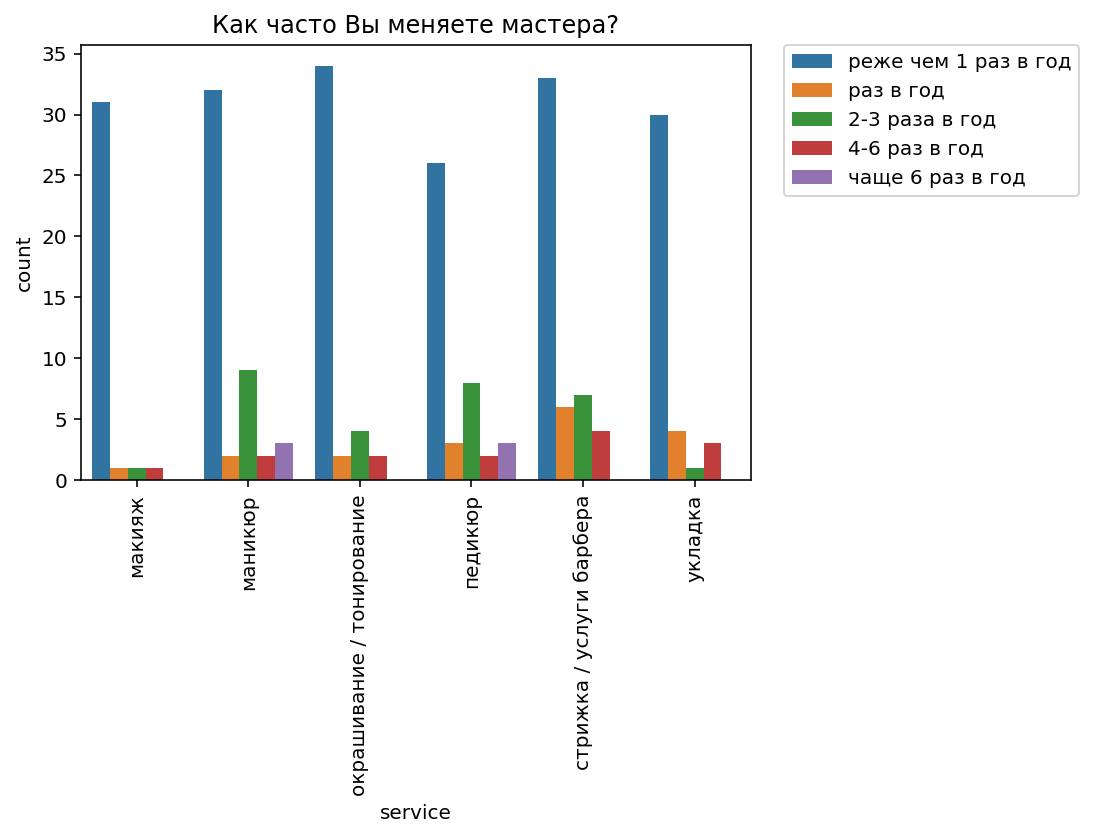

In [297]:
for q in ['Какими услугами и как часто Вы пользуетесь?',
          'Где предпочитаете оказание услуги?',
          'Ищите ли Вы примеры работ и как часто?',
          'Как часто Вы меняете мастера?']:
    plot_answers(df, q)

## Вопросы про услуги с несколькими вариантами ответа

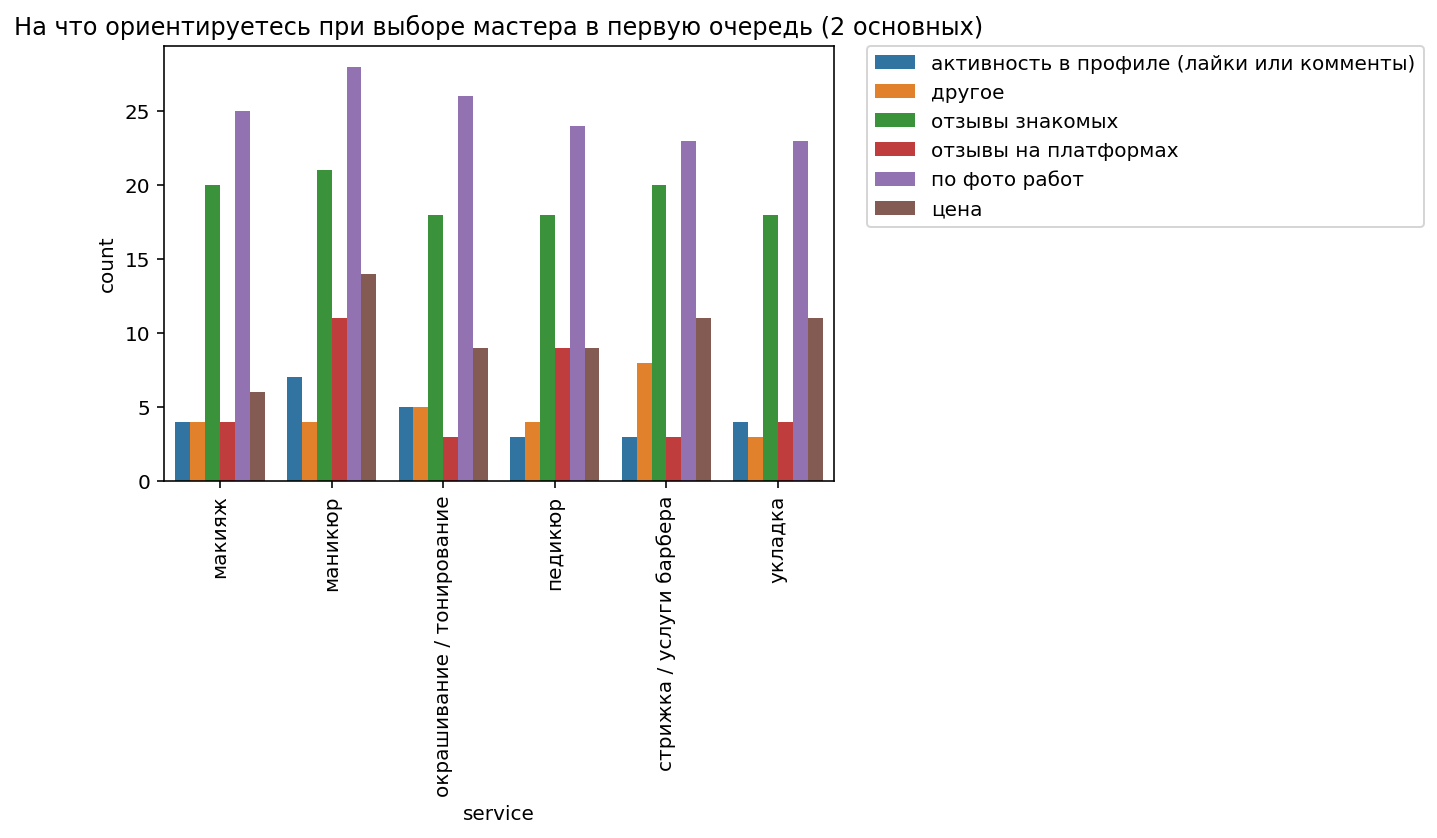

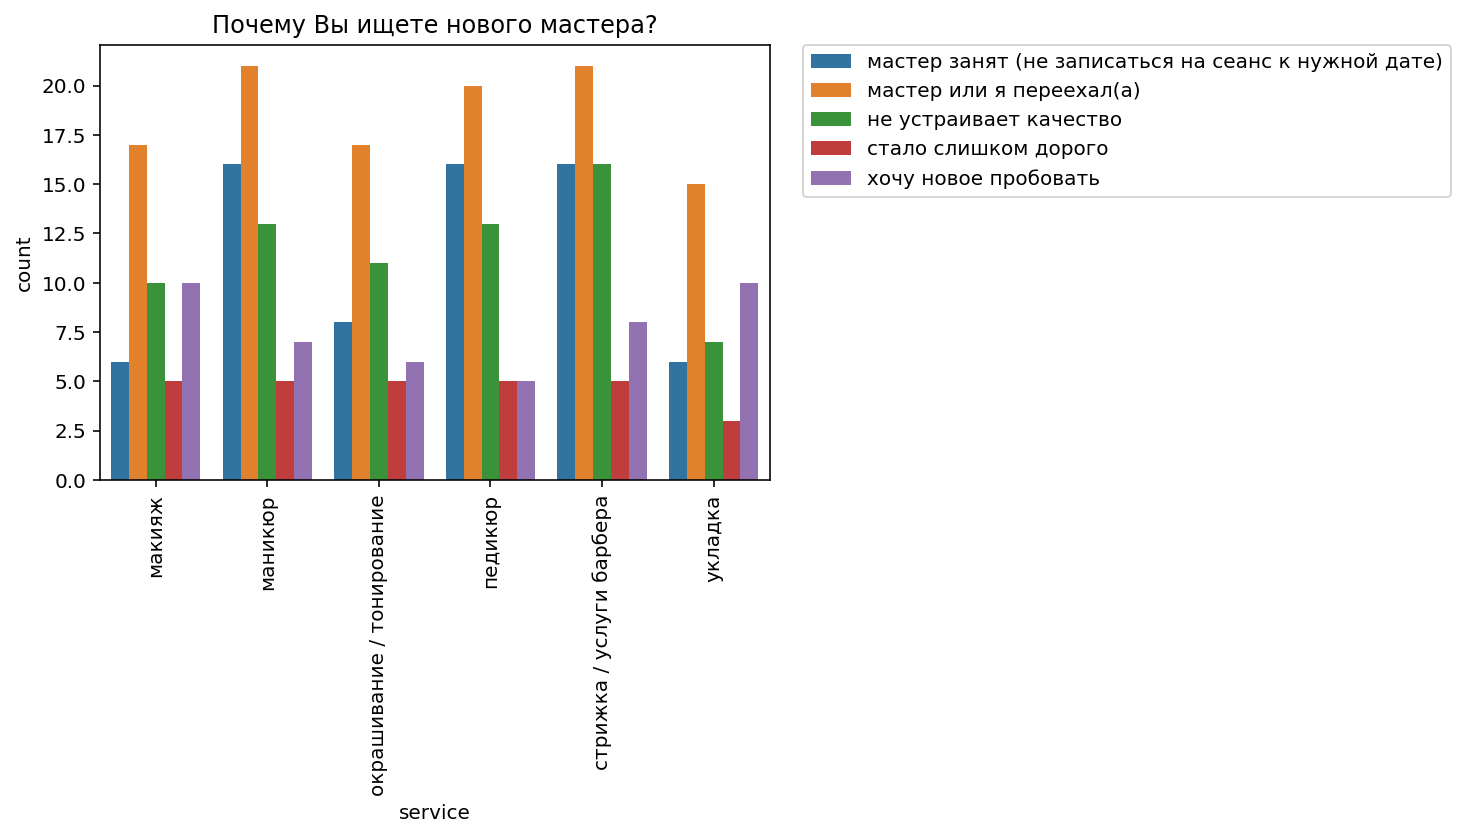

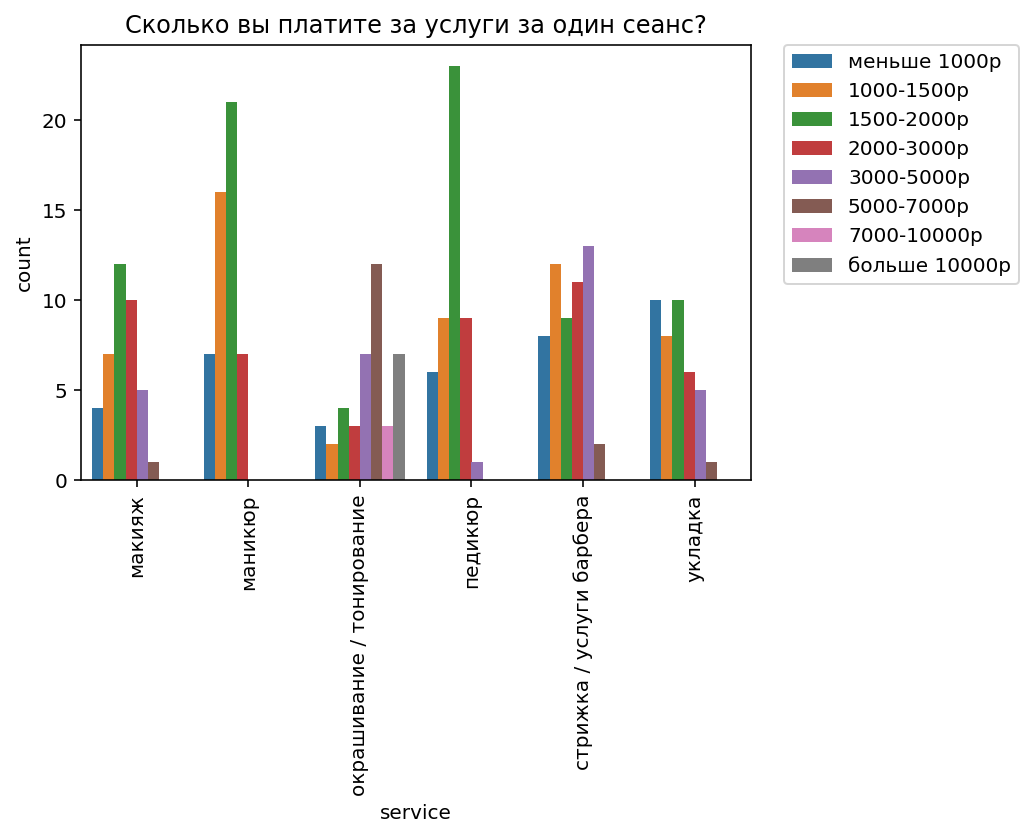

In [298]:
for q in ['На что ориентируетесь при выборе мастера в первую очередь (2 основных)',
          'Почему Вы ищете нового мастера?',
          'Сколько вы платите за услуги за один сеанс?']:
    plot_answers(df, q)    

## Остальные вопросы

In [299]:
other_questions = [c for c in df.columns if not any(q in c for q in questions) 
                   and 'Unnamed' not in c and c != 'Timestamp']
other_questions

['Где вы ищете примеры работ',
 'Как вы предпочитаете записываться',
 'Выберите самое сложное в поиске мастера',
 'А где ищете мастеров сейчас?',
 'В каком городе Вы проживаете?',
 'Укажите Ваш пол']

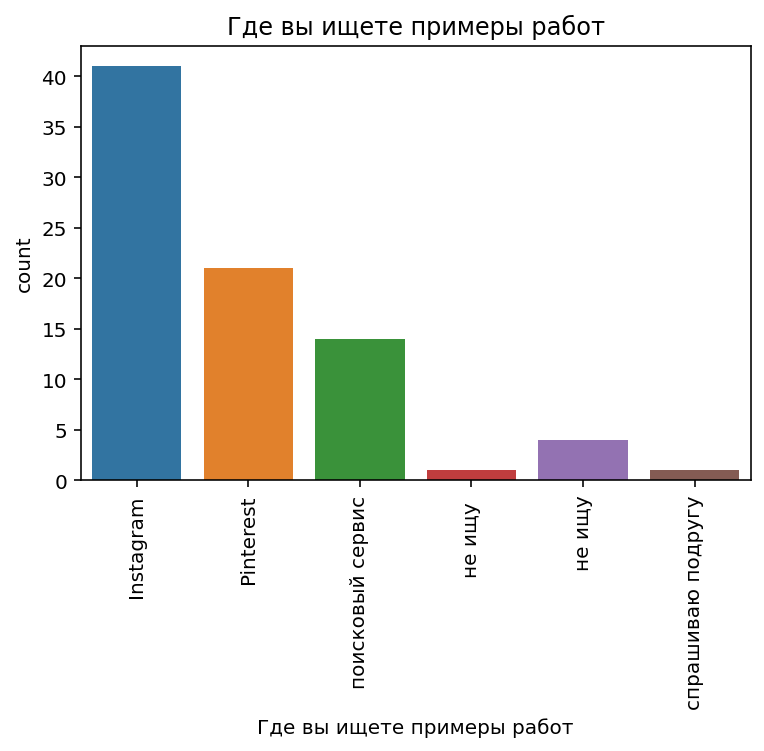

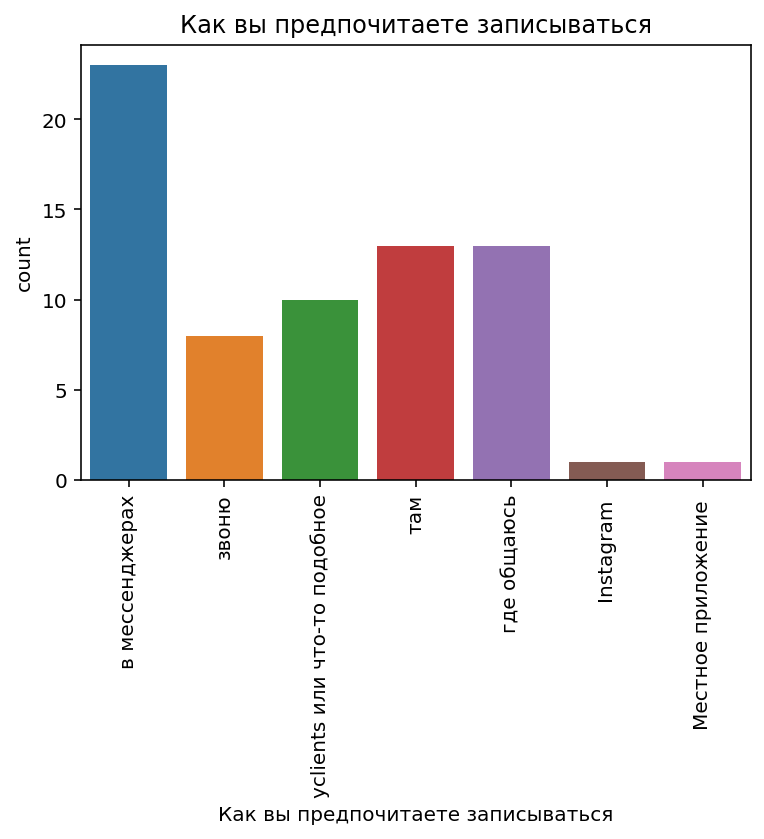

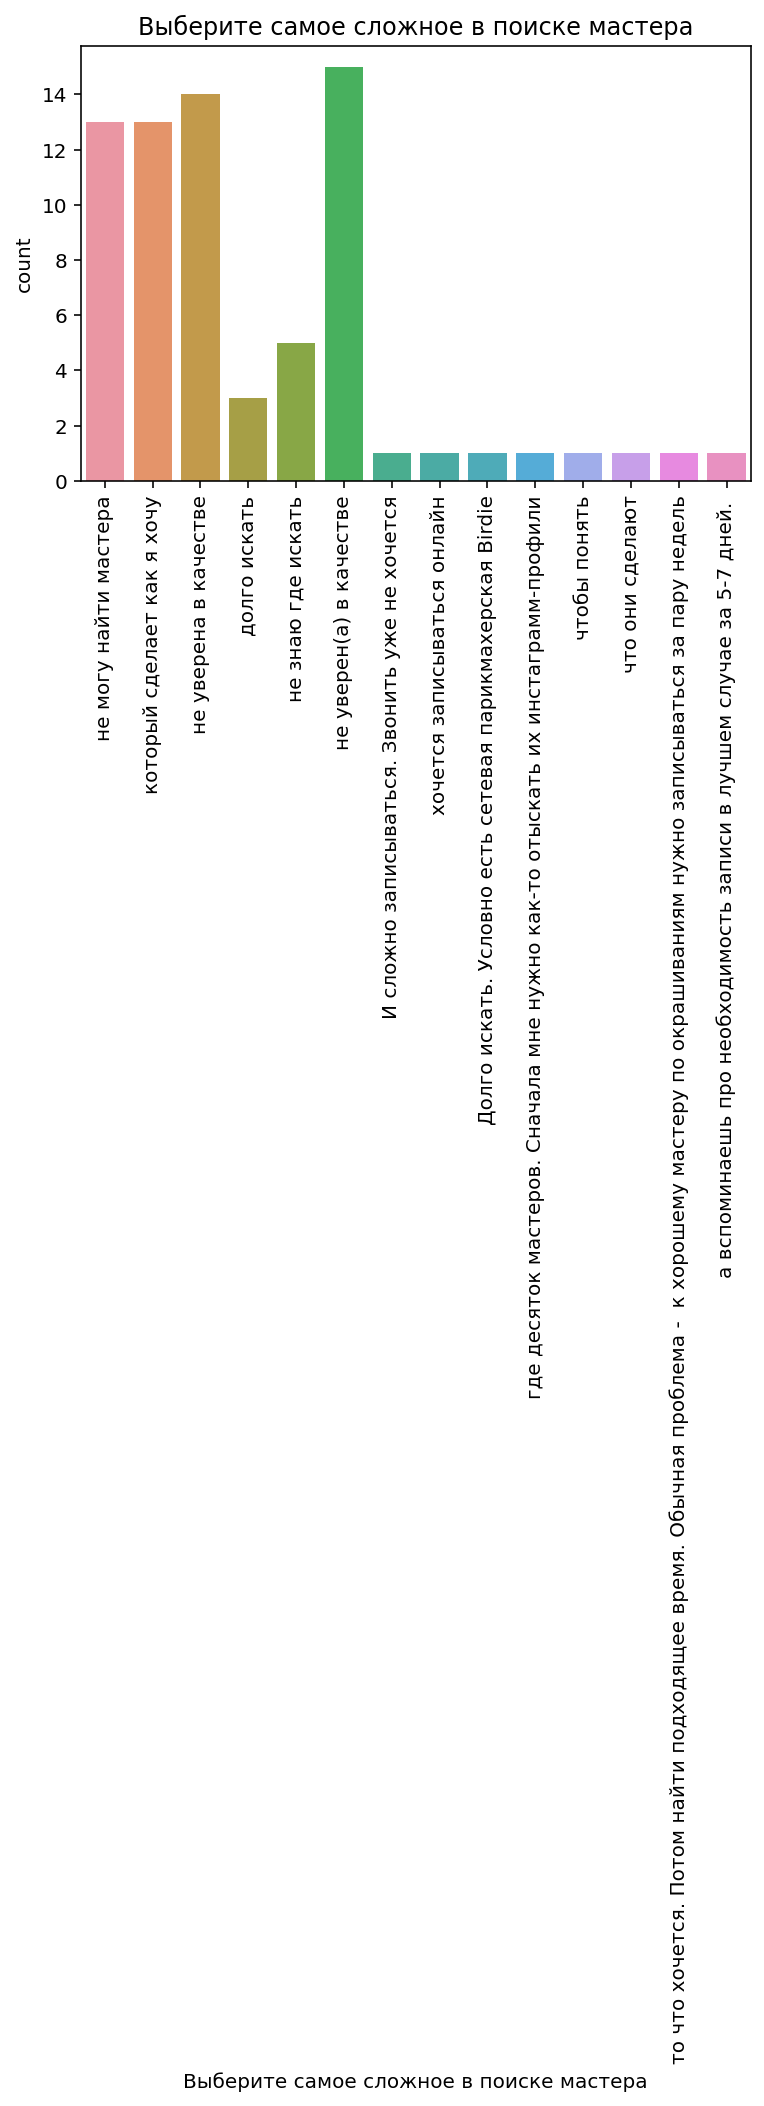

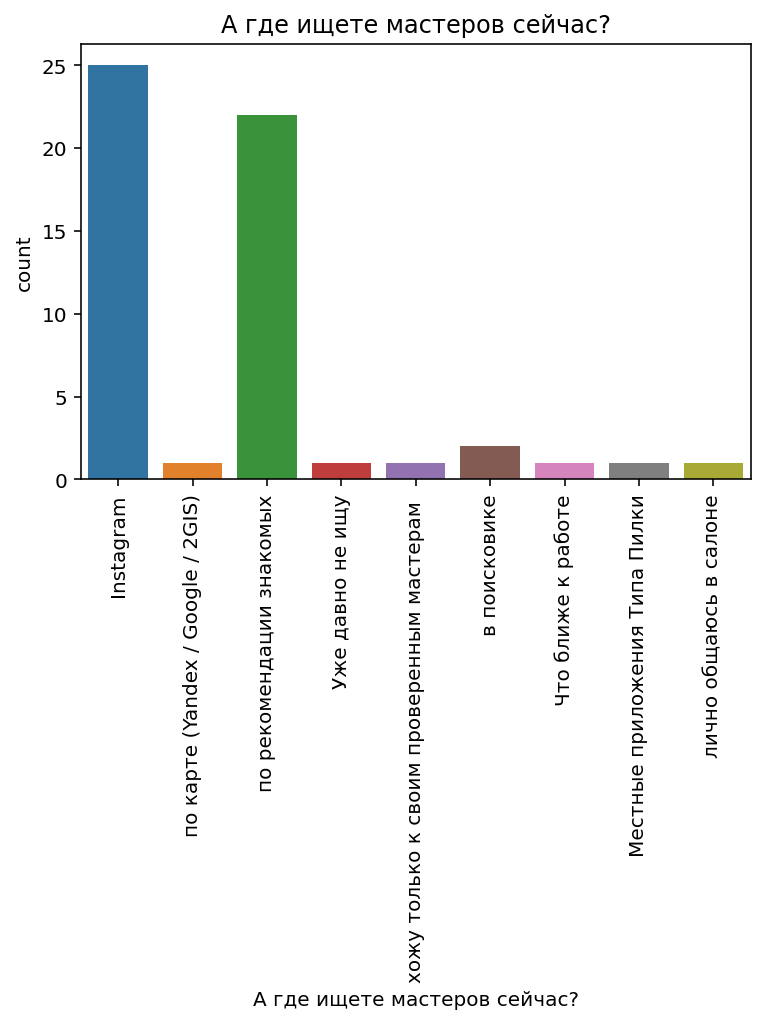

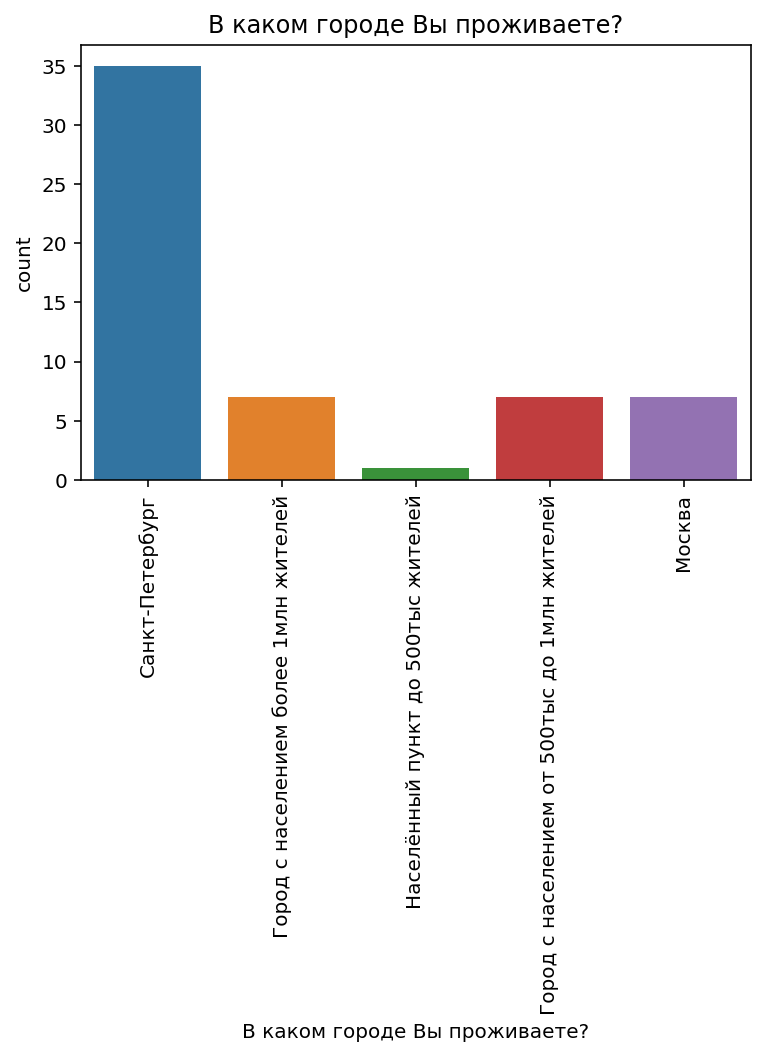

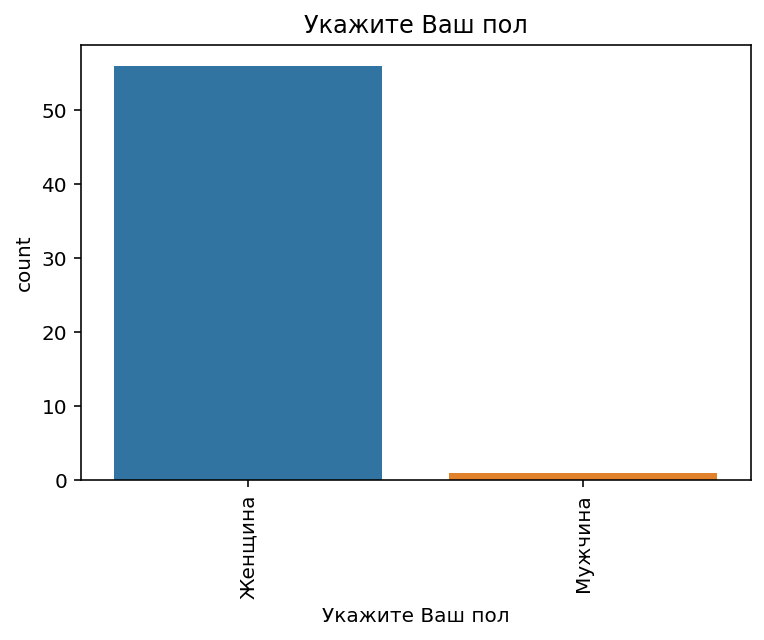

In [300]:
for q in other_questions:
    t = df[q]
    t = t.str.split(r'[ ]?,[ ]?').explode()
    sns.countplot(x=t)
    # Rotate ticks
    plt.xticks(rotation=90)
    # Put the legend out of the figure
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(q)
    plt.show()

## Оценка расходов на услуги в год на человека

In [314]:
def compute_cash_per_year(df):
    cash_per_year = {}
    for s in services:
        regularity_c = next(c for c in df.columns if c.startswith('Какими услугами и как часто Вы пользуетесь?') and s in c)
        price_c = next(c for c in df.columns if c.startswith('Сколько вы платите за услуги за один сеанс?') and s in c)
        t = df[[regularity_c, price_c]].copy()
        t.fillna(0, inplace=True)
        t[price_c] = [np.mean([PRICES[p] for p in str(ps).split(', ')]) for ps in t[price_c]]        
        t.replace(REGULARITY, inplace=True)
        cash_per_year[s] = int(np.dot(t[regularity_c], t[price_c]) / len(t))

    return pd.DataFrame(cash_per_year.items(), columns=['service', 'cash'])

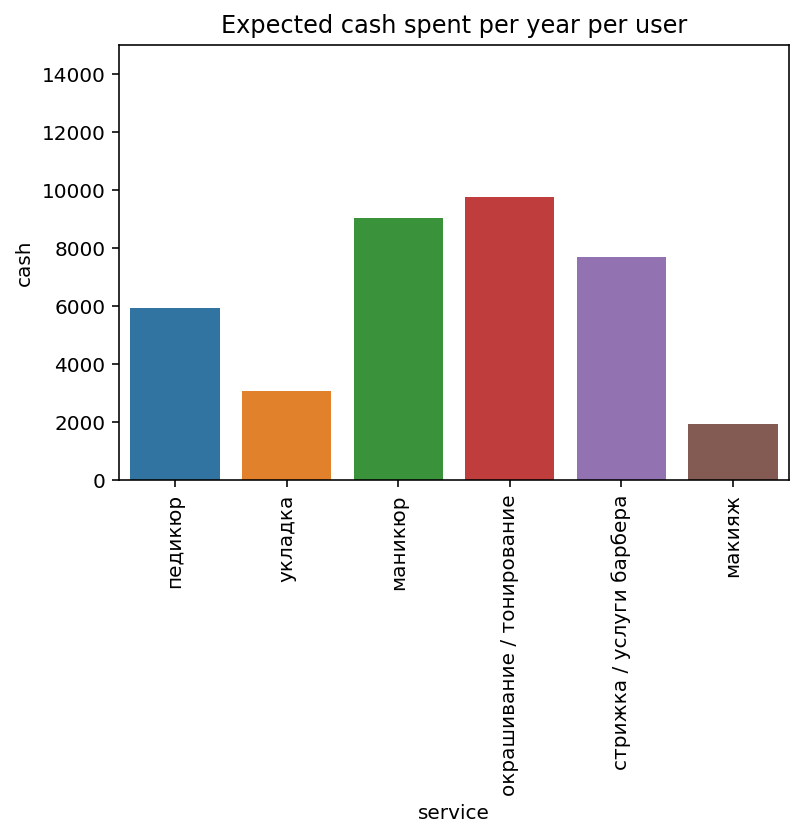

In [315]:
cpydf = compute_cash_per_year(df)
sns.barplot(data=cpydf, x='service', y='cash')
# Rotate ticks
plt.xticks(rotation=90)
plt.title('Expected cash spent per year per user')
plt.ylim(0, 15000)
plt.show()

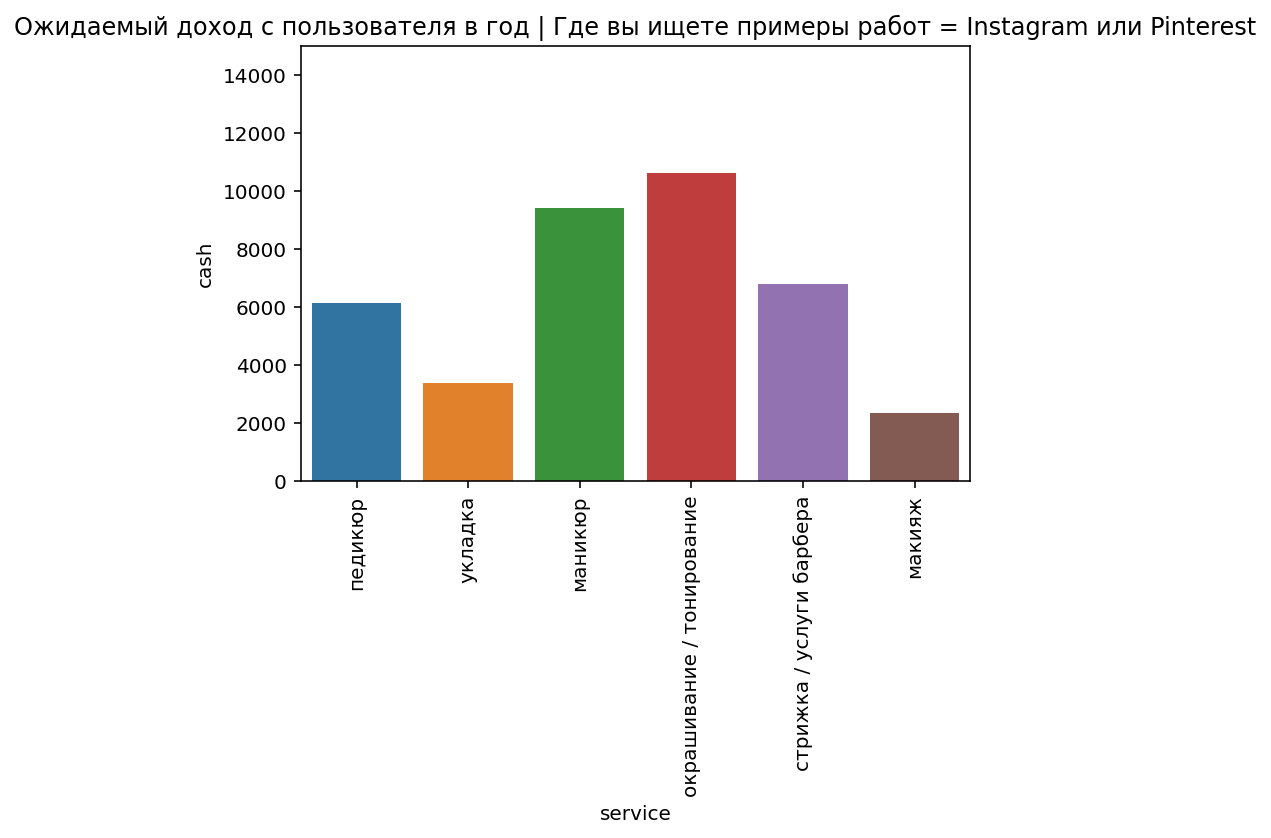

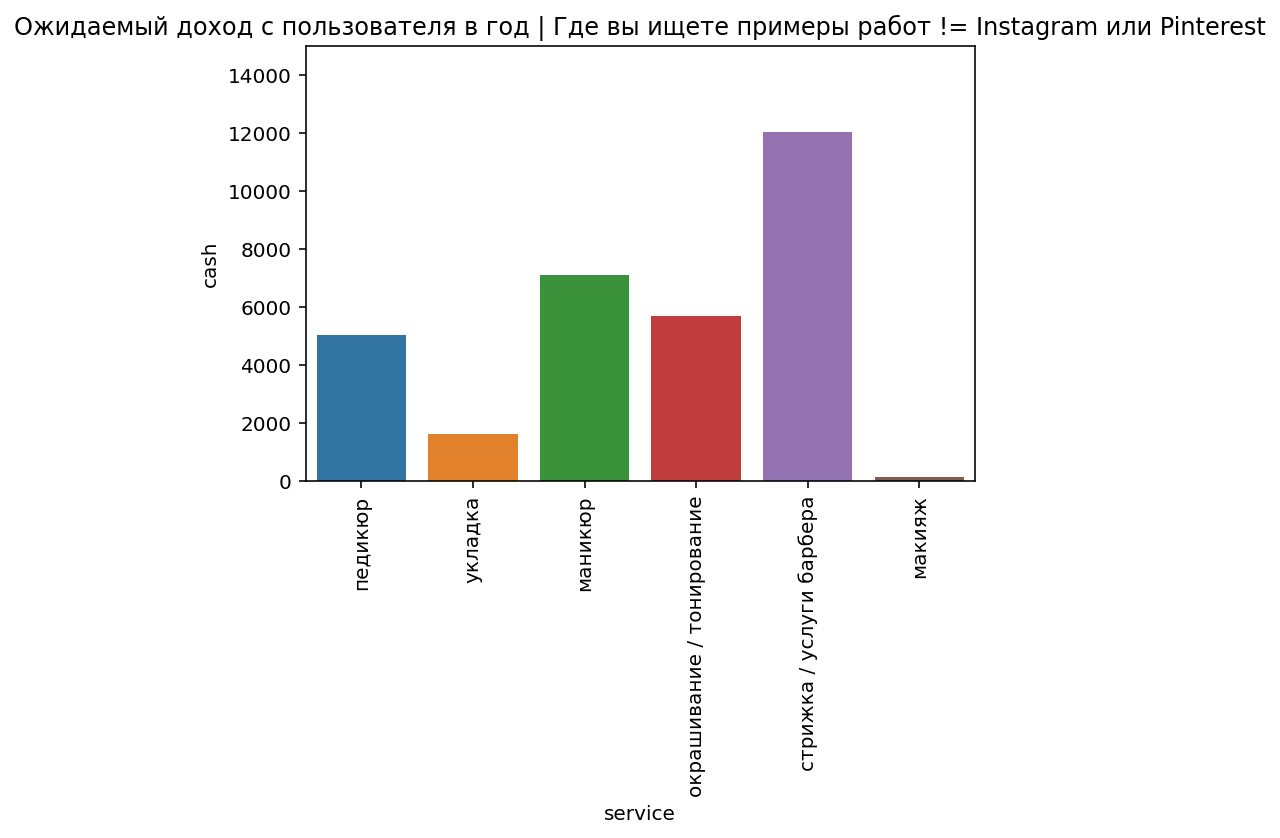

In [316]:
# Среди тех кто ищет работы в Instagram или Pinterest
t = df.loc[['Instagram' in str(v) or 'Pinterest' in str(v) for v in df['Где вы ищете примеры работ']]]
sns.barplot(data=compute_cash_per_year(t), x='service', y='cash')
# Rotate ticks
plt.xticks(rotation=90)
plt.title('Ожидаемый доход с пользователя в год | Где вы ищете примеры работ = Instagram или Pinterest')
plt.ylim(0, 15000)
plt.show()

# Среди тех кто не ищет работы в Instagram или Pinterest
t = df.loc[[not('Instagram' in str(v) or 'Pinterest' in str(v)) for v in df['Где вы ищете примеры работ']]]
sns.barplot(data=compute_cash_per_year(t), x='service', y='cash')
# Rotate ticks
plt.xticks(rotation=90)
plt.title('Ожидаемый доход с пользователя в год | Где вы ищете примеры работ != Instagram или Pinterest')
plt.ylim(0, 15000)
plt.show()

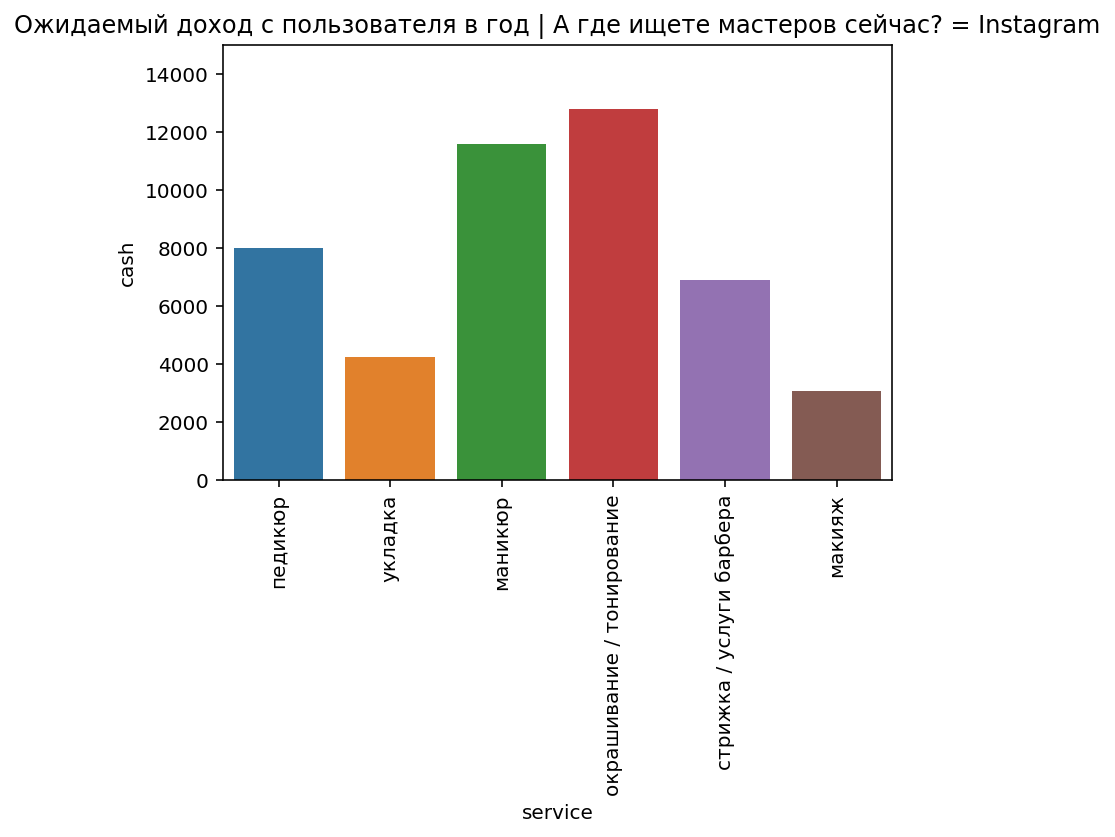

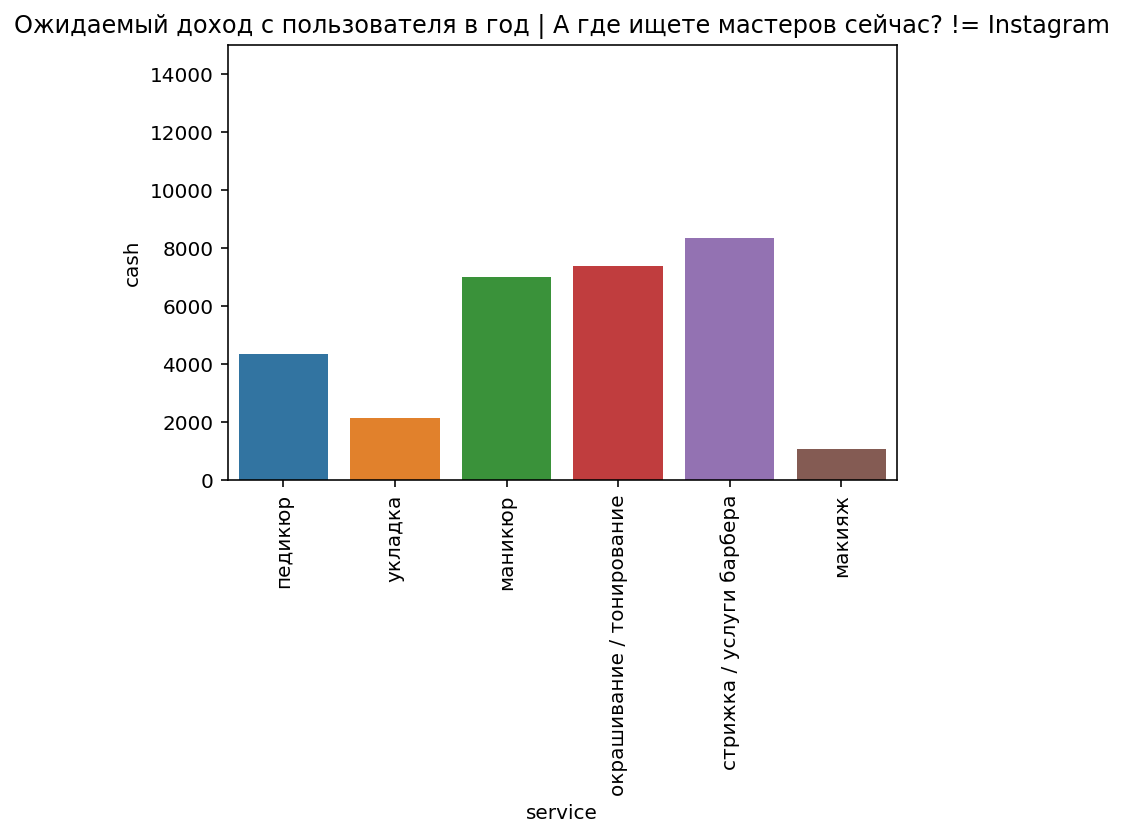

In [317]:
# Среди тех кто ищет мастеров в Instagram
t = df.loc[['Instagram' in str(v) for v in df['А где ищете мастеров сейчас?']]]
sns.barplot(data=compute_cash_per_year(t), x='service', y='cash')
# Rotate ticks
plt.xticks(rotation=90)
plt.title('Ожидаемый доход с пользователя в год | А где ищете мастеров сейчас? = Instagram')
plt.ylim(0, 15000)
plt.show()

# Среди тех кто не ищет мастеров в Instagram
t = df.loc[[not('Instagram' in str(v)) for v in df['А где ищете мастеров сейчас?']]]
sns.barplot(data=compute_cash_per_year(t), x='service', y='cash')
# Rotate ticks
plt.xticks(rotation=90)
plt.title('Ожидаемый доход с пользователя в год | А где ищете мастеров сейчас? != Instagram')
plt.ylim(0, 15000)
plt.show()

## Оценка объёма услуг, когда пользователя ищут мастера

In [352]:
def compute_new_cash_per_year(df):
    new_cash_per_year = {}
    for s in services:
        regularity_c = next(c for c in df.columns if c.startswith('Какими услугами и как часто Вы пользуетесь?') and s in c)
        new_c = next(c for c in df.columns if c.startswith('Как часто Вы меняете мастера?') and s in c)
        price_c = next(c for c in df.columns if c.startswith('Сколько вы платите за услуги за один сеанс?') and s in c)
        t = df[[regularity_c, new_c, price_c]].copy()
        t.fillna(0, inplace=True)
        t.replace(REGULARITY, inplace=True)        
        t[price_c] = [np.mean([PRICES[p] for p in str(ps).split(', ')]) for ps in t[price_c]]
        # Process each time correctly
        each_time_idx = np.flatnonzero([a == 'каждый раз' for a in t[new_c]])
        t.iloc[each_time_idx, 1] = t.iloc[each_time_idx, 0]    
        new_cash_per_year[s] = int(np.dot(t[new_c], t[price_c]) / len(t))

    return pd.DataFrame(new_cash_per_year.items(), columns=['service', 'cash'])

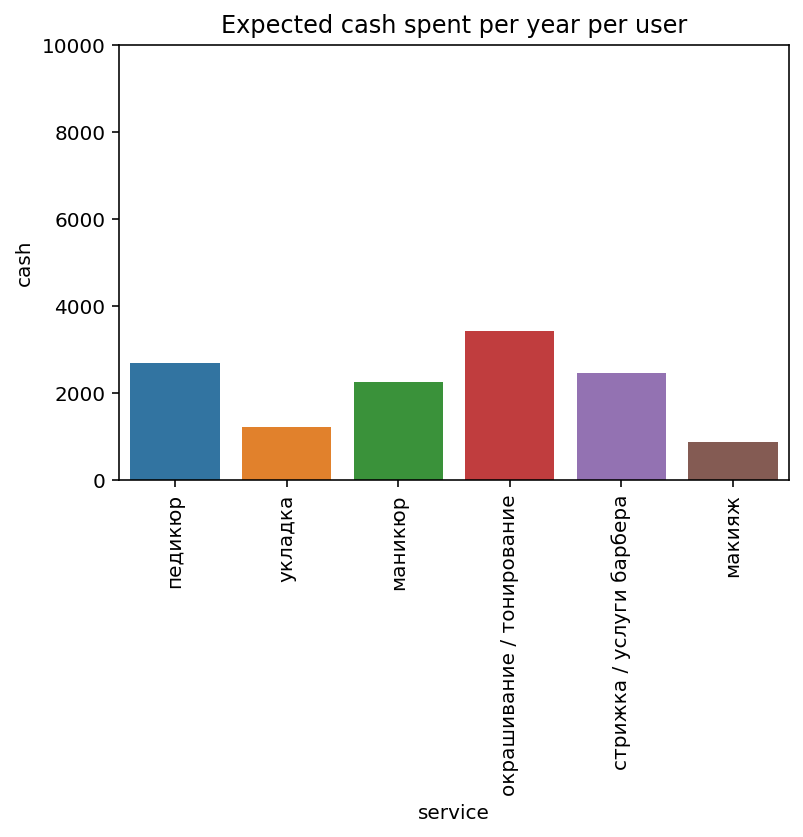

In [355]:
cpydf = compute_new_cash_per_year(df)
sns.barplot(data=cpydf, x='service', y='cash')
# Rotate ticks
plt.xticks(rotation=90)
plt.title('Expected cash spent per year per user')
plt.ylim(0, 10000)
plt.show()